In [186]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pymap3d as pm
from scipy.spatial.transform import Rotation
import math
from pathlib import Path
from utils import project_root

In [187]:
%matplotlib notebook
matplotlib.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,8)

# Extrinsic calibrations and globals

In [188]:
# seq: {‘X’, ‘Y’, ‘Z’} for intrinsic rotations, or {‘x’, ‘y’, ‘z’} for extrinsic rotations
# Wikipedia: The three elemental rotations may be extrinsic (rotations about the axes xyz 
# of the original coordinate system, which is assumed to remain motionless), or intrinsic 
# (rotations about the axes of the rotating coordinate system XYZ, 
# solidary with the moving body, which changes its orientation after each elemental rotation).
rot_order = 'xyz'

In [189]:
# IMU rotational offset
imu_rot_off = [0, 0, 1.5708]

In [190]:
R_b2i = Rotation.from_euler('z', 1.5708, degrees=False).as_matrix()
R_b2i

array([[-3.6732051e-06, -1.0000000e+00,  0.0000000e+00],
       [ 1.0000000e+00, -3.6732051e-06,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00]])

In [191]:
###### Test #######
R1 = R_b2i
R2 = Rotation.from_euler('xyz', [0, 0, 1.5708], degrees=False).as_matrix()
v = np.array([5, 2, 0]).reshape((3,1))
(R1@R2)@v

array([[-4.99998531],
       [-2.00003673],
       [ 0.        ]])

In [192]:
# GPS translational offset
x_off = -0.01
y_off = 0
z_off = 2.13
gps_off = np.array([x_off, y_off, z_off]).reshape((3,1))
print(gps_off)

[[-0.01]
 [ 0.  ]
 [ 2.13]]


In [193]:
GRAV = 9.80665

# Topic Covariance matrices

In [194]:
# GPS position_covariance:
gps_pos_cov = [[0.019599999999999996, 0, 0],
               [0, 0.019599999999999996, 0],
               [0, 0, 0.31359999999999993]]

In [195]:
# IMU covariances (noise) from /ouster/imu topic
lin_acc_cov = [[0.01, 0, 0],
              [0, 0.01, 0],
              [0, 0, 0.01]]
ang_vel_cov = [[0.0006, 0, 0],
              [0, 0.0006, 0],
              [0, 0, 0.0006]]

In [196]:
var_p = 0.019599999999999996
sigma_p = np.sqrt(var_p)
var_a = 0.01
sigma_a = np.sqrt(var_a)
var_w = 0.0006
sigma_w = np.sqrt(var_w)

# Helper functions

In [197]:
# page 25, Sola's
def quat2matrix(q):
    qw, qx, qy, qz = q
    
    R = [[qw**2 + qx**2 - qy**2 - qz**2, 2*(qx*qy - qw*qz),             2*(qx*qz + qw*qy)],
         [2*(qx*qy + qw*qz),             qw**2 - qx**2 + qy**2 - qz**2, 2*(qy*qz - qw*qx)],
         [2*(qx*qz - qw*qy),             2*(qy*qz + qw*qx),             qw**2 - qx**2 - qy**2 + qz**2]]
    
    return np.array(R).reshape((3,3))

# as defined in Sola, page 6
# The product of two rotation quaternions will be equivalent to the rotation a2 + b2i + c2j + d2k (q1)
# followed by the rotation a1 + b1i + c1j + d1k (q0).
def quat_mult(p, q):
    pw, px, py, pz = p
    qw, qx, qy, qz = q
    
    q_w = pw*qw - px*qx - py*qy - pz*qz
    q_x = pw*qx + px*qw + py*qz - pz*qy
    q_y = pw*qy - px*qz + py*qw + pz*qx
    q_z = pw*qz + px*qy - py*qx + pz*qw
    
    retq = np.array([q_w, q_x, q_y, q_z]).reshape((4,1))

    return retq

def euler2quat(e_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler(axis, e_in.flatten())

    # Convert to quaternions
    rot_quat = rot.as_quat() # [x, y, z, w]
    
    retval = np.array([rot_quat[3], rot_quat[0], rot_quat[1], rot_quat[2]]).reshape((4,1)) # [w, x, y, z]
    
    return retval

def euler2matrix(e_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler(axis, e_in.flatten())

    # Convert to quaternions
    rot_matrix = rot.as_matrix().reshape((3,3))
        
    return rot_matrix

def quat2euler(q_in, axis=rot_order):
    q_in_ = np.array([q_in[1], q_in[2], q_in[3], q_in[0]]).reshape((4,1)) # [w, x, y, z] -> [x, y, z, w]
    
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_quat(q_in_.flatten()) # [x, y, z, w]

    # Convert to euler
    rot_euler = rot.as_euler(axis) # [x,y,z]
    
    return rot_euler.reshape((3,1))

def matrix2euler(R_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_matrix(R_in)

    # Convert to quaternions
    rot_e = rot.as_euler(axis).reshape((3,1))
        
    return rot_e

# Load data

In [198]:
os.chdir(Path(project_root() / 'data/topics'))

## GPS data

### WGS84 (lattitude, longitude, altitude) - "/gps/fix"

In [199]:
lines = []
with open('gps.txt') as f:
    lines = f.readlines()

In [200]:
lattitude = []
longitude = []
altitude = []
sec_gps = []
nsec_gps = []
count = 0
for line in lines:
    count += 1
    if line[4:7] == "sec":
        sec_gps.append(int(line[9:-1]))
    elif line[4:11] == "nanosec":
        nsec_gps.append(int(line[13:-1]))
    elif line[0:3] == "lat":
        lattitude.append(float(line[10:-1]))
    elif line[0:3] == "lon":
        longitude.append(float(line[11:-1]))
    elif line[0:3] == "alt":
        altitude.append(float(line[10:-1]))

In [201]:
temp = [i*1e-9 for i in nsec_gps]
t_gps = [sum(x) for x in zip(sec_gps, temp)]
tt_gps = np.array([x-t_gps[0] for x in t_gps])

### Positions (x_gps, y_gps, z_gps) - base_link frame

In [202]:
lat_0 = lattitude[0]
lon_0 = longitude[0]
alt_0 = altitude[0]

x_gps = []
y_gps = []
z_gps = []
for i in range(len(lattitude)):
    # get [east, noth, up] w.r.t. an origin and assume it is [y, x, z]
    x_, y_, z_ = pm.geodetic2enu(lattitude[i], longitude[i], altitude[i], lat_0, lon_0, alt_0, ell=None, deg=True)
    # add the extrinsic calibration offset, so that the coordinates are w.r.t. "base_link", not "gps"
    x_gps.append(x_ + gps_off[0])
    y_gps.append(y_ + gps_off[1])
    z_gps.append(z_ + gps_off[2])

x_gps = np.array(x_gps)
y_gps = np.array(y_gps)
z_gps = np.array(z_gps)

### Velocities

In [203]:
vx_gps = []
vy_gps = []
vz_gps = []
for i in range(len(tt_gps)):

    # in the first iteration, get x,y from gps and theta from imu
    if i==0:
        vx, vy, vz = 0, 0, 0
    # in the rest, get it from kinematics
    else:
        # get dt in seconds
        dt = tt_gps[i] - tt_gps[i-1]
        if dt<0:
            print(f"Error! Negative dt: {dt}")

        # now depending on dt and the linear and angular velocities, we can upgate the positions with kinematics
        vx = (x_gps.flatten()[i] - x_gps.flatten()[i-1])/dt
        vy = (y_gps.flatten()[i] - y_gps.flatten()[i-1])/dt
        vz = (z_gps.flatten()[i] - z_gps.flatten()[i-1])/dt
        
    vx_gps.append(vx)
    vy_gps.append(vy)
    vz_gps.append(vz)

vx_gps = np.array(vx_gps)
vy_gps = np.array(vy_gps)
vz_gps = np.array(vz_gps)

### Accelerations

In [204]:
ax_gps = []
ay_gps = []
az_gps = []
for i in range(len(tt_gps)):

    # in the first iteration, get x,y from gps and theta from imu
    if i==0:
        ax, ay, az = 0, 0, 0
    # in the rest, get it from kinematics
    else:
        # get dt in seconds
        dt = tt_gps[i] - tt_gps[i-1]
        if dt<0:
            print(f"Error! Negative dt: {dt}")

        # now depending on dt and the linear and angular velocities, we can upgate the positions with kinematics
        ax = (vx_gps.flatten()[i] - vx_gps.flatten()[i-1])/dt
        ay = (vy_gps.flatten()[i] - vy_gps.flatten()[i-1])/dt
        az = (vz_gps.flatten()[i] - vz_gps.flatten()[i-1])/dt
        
    ax_gps.append(ax)
    ay_gps.append(ay)
    az_gps.append(az)

ax_gps = np.array(ax_gps)
ay_gps = np.array(ay_gps)
az_gps = np.array(az_gps)

### Plot positions when static to find variances

In [205]:
m = 30
t = np.arange(m)

[-0.0096609   0.01762649  2.13443333]


<IPython.core.display.Javascript object>


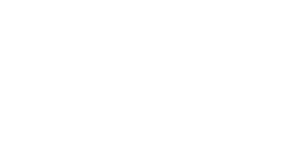

In [206]:
gps_bias = np.array([np.mean(x_gps[0:m]), np.mean(y_gps[0:m]), np.mean(z_gps[0:m])])
print(gps_bias)

plt.plot(t, x_gps[0:m], label="x")
plt.plot(t, y_gps[0:m], label="y")
plt.plot(t, z_gps[0:m], label="z")
plt.title("GPS - positions")
plt.ylabel("dist (m)")
plt.xlabel("# iter")
plt.legend()
plt.show()

In [207]:
v_x = np.var(x_gps[0:m])
v_y = np.var(y_gps[0:m])
v_z = np.var(z_gps[0:m])
print("Gps variances: ", v_x, v_y, v_z)
print("Gps std. deviations: ", np.sqrt(v_x), np.sqrt(v_y), np.sqrt(v_z))

Gps variances:  1.1960487593898167e-05 0.00014961380391449012 9.764555605550465e-05
Gps std. deviations:  0.0034583937881476376 0.012231672163465228 0.009881576597664194


### Plot positions over the entire dataset

In [208]:
plt.plot(x_gps, label="x")
plt.plot(y_gps, label="y")
plt.plot(z_gps, label="z")
plt.title("GPS - positions")
plt.ylabel("dist(m)")
plt.xlabel("# iteration")
plt.legend()
plt.show()

## IMU data (orientation, ang_vel, lin_acc) - "/ouster/imu"

### Load IMU data

In [209]:
lines = []
with open('imu.txt') as f:
    lines = f.readlines()

In [210]:
ang_vel = [] # [w_x, w_y, w_z]
ang_vel_e = []
lin_acc = [] # [x_ddot, y_ddot, z_ddot]
sec_imu = []
nsec_imu = []
count = 0

for idx, line in enumerate(lines):
    count += 1
    if line[4:7] == "sec":
        sec_imu.append(int(line[9:-1]))
    elif line[4:11] == "nanosec":
        nsec_imu.append(int(line[13:-1]))
    elif line[0:-1] == "orientation:":
        qx = float(lines[idx+1][5:-1])
        qy = float(lines[idx+2][5:-1])
        qz = float(lines[idx+3][5:-1])
        qw = float(lines[idx+4][5:-1])
    elif line[0:-1] == "angular_velocity:":
        w_x = float(lines[idx+1][5:-1])
        w_y = float(lines[idx+2][5:-1])
        w_z = float(lines[idx+3][5:-1])
        ang_vel.append([w_x, w_y, w_z])
        ang_vel_e.append([np.rad2deg(w_x), np.rad2deg(w_y), np.rad2deg(w_z)])
    elif line[0:-1] == "linear_acceleration:":
        a_x = float(lines[idx+1][5:-1])
        a_y = float(lines[idx+2][5:-1])
        a_z = float(lines[idx+3][5:-1])
        lin_acc.append([a_x, a_y, a_z])

ang_vel = np.array(ang_vel)
ang_vel_e = np.array(ang_vel_e)
lin_acc = np.array(lin_acc)

In [211]:
temp = [i*1e-9 for i in nsec_imu]
t_imu = [sum(x) for x in zip(sec_imu, temp)]
tt_imu = [x-t_imu[0] for x in t_imu]

### Find IMU bias

In [212]:
m = 300
t = np.arange(m)

In [213]:
static_ang_vel = np.array(ang_vel)[0:m,:]
ang_vel_imu_bias = np.mean(static_ang_vel, axis=0)
print(ang_vel_imu_bias)

plt.plot(t, ang_vel_e[0:m,0], label="w_x")
plt.plot(t, ang_vel_e[0:m,1], label="w_y")
plt.plot(t, ang_vel_e[0:m,2], label="w_z")
plt.title("IMU - angular velocity")
plt.legend()
plt.show()

[-0.01907755  0.01299578 -0.00510084]


In [214]:
static_lin_acc = np.array(lin_acc)[0:m,:]
lin_acc_imu_bias = np.mean(static_lin_acc, axis=0)
lin_acc_imu_bias[2] = lin_acc_imu_bias[2] - GRAV # remove gravity, as this is not a bias
print(lin_acc_imu_bias)

plt.plot(t, lin_acc[0:m,0], label="a_x")
plt.plot(t, lin_acc[0:m,1], label="a_y")
plt.plot(t, lin_acc[0:m,2], label="a_z")
plt.title("IMU - linear acceleration")
plt.legend()
plt.show()

[ 0.10895214 -0.80556905 -0.09362127]


### Plot IMU data (w. bias) for the entire dataset

In [215]:

plt.plot(tt_imu, ang_vel_e[:,0], label="w_x")
plt.plot(tt_imu, ang_vel_e[:,1], label="w_y")
plt.plot(tt_imu, ang_vel_e[:,2], label="w_z")
plt.title("IMU - angular velocity")
plt.legend()
plt.show()

In [216]:
plt.plot(tt_imu, lin_acc[:,0], label="a_x")
plt.plot(tt_imu, lin_acc[:,1], label="a_y")
plt.plot(tt_imu, lin_acc[:,2], label="a_z")
plt.title("IMU - linear acceleration")
plt.legend()
plt.show()

### Extract orientation (based on initial orientation from manual tunning in radar odometry)

In [217]:
theta0_z = 0.3
q_imu_list = np.empty((0,4), float)
q_prev = euler2quat(np.array([0, 0, theta0_z]))
for i in range(len(tt_imu)):
    # in the first iteration, set theta = 0
    if i==0:
        q_next = euler2quat(np.array([0, 0, theta0_z]))
    # in the rest, get it from kinematics
    else:
        # get dt in seconds
        dt = tt_imu[i] - tt_imu[i-1]
        if dt<0:
            print(f"Error! Negative dt: {dt}")
         
        # find the current robot rotation matrix
        R_robot = quat2matrix(q_prev)
        R = R_b2i.T@R_robot
        
        # new orientation based on quaternion kinematics       
        w_theta = R@(ang_vel[i] - ang_vel_imu_bias)*dt
        w_norm = np.linalg.norm(w_theta)
        q_w = np.cos(w_norm/2)
        q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
        q_omega = np.hstack((q_w, q_xyz.flatten())).reshape((4,1)) 
        
        q_next = quat_mult(q_prev, q_omega)
        r_next = quat2euler(q_next, rot_order)
            
    q_imu_list = np.append(q_imu_list, q_next.T, axis=0)
        
    q_prev = q_next

In [218]:
theta_imu_list = np.empty((0,3), float)
for x in q_imu_list:
    th = quat2euler(x)
    theta_imu_list = np.append(theta_imu_list, th.T, axis=0)

<IPython.core.display.Javascript object>


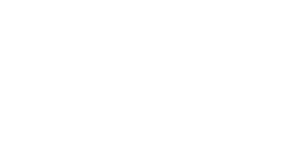

In [219]:
fig, axs = plt.subplots()

axs.plot(tt_imu, np.rad2deg(theta_imu_list[:,0]), label="theta_x")
axs.plot(tt_imu, np.rad2deg(theta_imu_list[:,1]), label="theta_y")
axs.plot(tt_imu, np.rad2deg(theta_imu_list[:,2]), label="theta_z")

plt.title("IMU - orientation")
plt.legend()
plt.show()

# IMU - GPS sensor fusion

Following "Error State Extended Kalman Filter Multi-Sensor Fusion for
Unmanned Aerial Vehicle Localization in GPS and Magnetometer
Denied Indoor Environments" by Lovro M. et al.

## Functions

### Nominal state - large signal : IMU

In [220]:
# update of the nominal state (ignores noise & inaccuracies) based on system dynamics
def nominal_state(dt, x_prev, a_imu, omega_imu):
    p_prev = x_prev[0:3]
    v_prev = x_prev[3:6]
    q_prev = x_prev[6:10]
    a_b = x_prev[10:13]
    omega_b = x_prev[13:16]
    g = x_prev[16:19]
    p_i = x_prev[19:22]
    q_i = x_prev[22:26]
    # find the current robot rotation matrix
    R_robot = quat2matrix(q_prev)
    
    # extract the current Rotation (IMU frame rotation + robot rotation)
    R = R_b2i.T@R_robot
    
    # angular velocity
    w_theta = R@(omega_imu - omega_b)*dt
    w_norm = np.linalg.norm(w_theta)
    q_w = np.cos(w_norm/2)
    q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
    q_omega = np.hstack((q_w, q_xyz.flatten())).reshape((4,1))   

    # apply dynamics to position, velocity and orientation
    p = p_prev + v_prev*dt + 0.5*(R @ (a_imu-a_b) + g)*(dt**2)
    v = v_prev + (R @ (a_imu - a_b) + g)*dt
    
    q = quat_mult(q_prev, q_omega)    
    
    # the nominal state
    x_out = np.vstack((p, v, q, a_b, omega_b, g, p_i, q_i))
    
    return x_out

### Prediction ( Error state) : IMU

In [221]:
def predict(dt, x, dx_prev, P_prev, 
            a_imu, omega_imu):
    
    Fx = F_x(dt, x, a_imu, omega_imu)
    Fw = F_w()
    Qw = Q_w(dt)

#     dx = Fx @ dx_prev #+ Fw @ w # this is always zero!

    t1 = (Fx @ P_prev) @ Fx.T
    t2 = (Fw @ Qw) @ Fw.T

    P = t1 + t2 # this is the only term we are interested in
    
    return dx, P

In [222]:
# calculate state transition matrix (including drift - last 6 elements)
def F_x(dt, x, a_imu, omega_imu):
    # extract linear acceleration and angular velocity biases
    a_b = x[10:13]
    omega_b = x[13:16]
    # find the current robot rotation matrix
    q_ = x[6:10]
    R_robot = quat2matrix(q_)
    
    # extract the current Rotation (IMU frame rotation + robot rotation)
    R = R_b2i.T @ R_robot

    # linear acceleration
    real_a = a_imu - a_b
    # angular velocity
    w_theta = R@(omega_imu - omega_b)*dt
    
    # extract dq from angular velocity
    w_norm = np.linalg.norm(w_theta)
    q_w = np.cos(w_norm/2)
    q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
    q_omega = np.hstack((q_w, q_xyz.flatten())).reshape((4,1))    
    
    # convert dq to rotation matrix
    Rw = quat2matrix(q_omega.flatten())

    # shortcuts
    A = skew(real_a)
    RA = R @ A
    
    F = np.zeros((24, 24))
    F[0:3, 0:3] = I3
    F[0:3, 3:6] = I3*dt
    
    F[3:6, 3:6] = I3
    F[3:6, 6:9] = -RA*dt
    F[3:6, 9:12] = -R*dt
    F[3:6, 15:18] = I3*dt
    
    F[6:9, 6:9] = Rw.T
    F[6:9, 12:15] = -I3*dt
    
    F[9:24, 9:24] = np.eye(15)
        
    return F

In [223]:
# calculate noise state transition matrix
def F_w():    
    M = np.zeros((24,12))
    M[3:6, 0:3] = I3
    M[6:9, 3:6] = I3
    M[9:12, 6:9] = I3
    M[12:15, 9:12] = I3

    return M

In [224]:
# calculate noise covariance
def Q_w(dt):
    
    Q = np.zeros((12,12))
    Q[0:3, 0:3] = var_v * I3 * dt**2
    Q[3:6, 3:6] = var_theta * I3 * dt**2
    Q[6:9, 6:9] = var_alpha * I3 * dt**2
    Q[9:12, 9:12] = var_omega * I3 * dt**2
    
    return Q

In [225]:
# page 17 - Solas
# calculate skew symmetric matrix of vector in se(3)
def skew(x):
    x = x.flatten()
    
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]]).reshape((3,3))

### True state : GPS

In [226]:
def true_state(x_in, dx):  
    p = x_in[0:3]
    v = x_in[3:6]
    q = x_in[6:10]
    a = x_in[10:13]
    w = x_in[13:16]
    g = x_in[16:19]
    p_i = x_in[19:22]
    q_i = x_in[22:26]
    
    dp = dx[0:3]
    dv = dx[3:6]
    dtheta = dx[6:9]
    dq = euler2quat(dtheta, rot_order)
    da = dx[9:12]
    dw = dx[12:15]
    dg = dx[15:18]
    dp_i = dx[18:21]
    dtheta_i = dx[21:24]
    dq_i = euler2quat(dtheta_i, rot_order)
    
    p_t = p + dp
    v_t = v + dv
    q_t = quat_mult(q, dq)
    a_t = a + da
    w_t = w + dw
    g_t = g + dg
    p_i_t = p_i + dp_i
    q_i_t = quat_mult(q_i, dq_i)
    
    x_out = np.vstack((p_t, v_t, q_t, a_t, w_t, g_t, p_i_t, q_i_t))

    return x_out

### Correction - Final step : GPS

In [227]:
# flag: 0 -> position sensor, 1 -> orientation sensor, 2 -> otherwise
def correct(x, P, y_mu, V, flag):    
    # Kalman gain
    H = get_H(x, y_mu, flag) # jacobian
    K = (P @ H.T) @ np.linalg.inv(((H@P)@H.T) + V) # Kalman gain
    
    # error
    h = get_h(x, flag)
    innov = get_innov(x, y_mu, h, flag)
    dx = K @ innov
    
    # covariance update
    P = (np.eye(24) - (K@H)) @ P
    
    return innov, dx, P

In [228]:
def get_innov(x, mu, h, flag):
    if flag==0: # position measurement
        inno = mu - h
    elif flag==1: # orientation measuremnt
        e = quat2euler(h)
        R = quat2matrix(h)
        print("R.T@e: ", R.T@e)

        q_mu = euler2quat(mu)
        R_mu = quat2matrix(q_mu)
                
        # page 19, Solas
        R_inno = R.T@R_mu
        print("R.T: ", R.T)
        print("R_mu: ", R_mu)
        print("R_inno: ", R_inno)
        phi = np.arccos( (np.trace(R_inno) - 1)/2 )
        print("Phi: ", phi)
        u = v_func(R_inno - R_inno.T)/(2 * np.sin(phi))
        
        inno = u*phi
#         inno = matrix2euler(R_inno) - quat2euler(h)
        print("Innovation: ", inno)
    
    return inno

In [229]:
# flag: 0 -> position sensor, 1 -> orientation sensor, 2 -> otherwise
def get_h(x, flag=0):        
    if flag == 0:
        p_t = x[0:3]
        p_i = x[19:22]
        q_i = x[22:26]
        R_qi = quat2matrix(q_i)
        
        ret = np.matmul(R_qi, p_t) + p_i
        
        return ret
    elif flag == 1:
        q_t = x[6:10]
        q_i = x[22:26]
        
        ret = quat_mult(q_i, q_t)

        return ret
    else:
        return x

In [230]:
def get_H(x, mu, flag):    
    J1 = Jac1(x, mu, flag)
    J2 = Jac2(x)
    J = J1 @ J2 

    return J

### ESKF reset : GPS

In [231]:
def reset(dx, P):
    dtheta = dx[6:9]
    
    G = np.zeros((24,24))
    G[0:6, 0:6] = np.eye(6)
    G[6:9, 6:9] = I3 - skew(0.5*dtheta)
    G[9:24, 9:24] = np.eye(15)
    
#     P = (G @ P) @ G.T # for better accuracy
    P = P
    dx = np.zeros((24,1))
    
    return dx, P

### Jacobians

In [232]:
def Jac1(x, mu, flag):
    J1 = np.zeros((3,26))
    
    if flag==0: # position measurement
        q_i = x[22:26]
        J1[0:3, 0:3] = quat2matrix(q_i)
        J1[0:3, 19:22] = I3
    elif flag==1: # orientation measurement
        J1[0:3, 6:9] = I3
        J1[0:3, 22:25] = quat2matrix(mu).T
        
    return J1

In [233]:
def Jac2(x):
    q = x[6:10]
    q_i = x[22:26]
    
    J2 = np.zeros((26,24))
    
    J2[0:3, 0:3] = I3
    J2[3:6, 3:6] = I3
    J2[6:10, 6:9] = Jac3(q)
    J2[10:22, 9:21] = np.eye(12)
    J2[22:26, 21:24] = Jac3(q_i)

    return J2

In [234]:
def Jac3(q):
    q_w, q_x, q_y, q_z = q
    
    return 0.5 * np.array([[-q_x, -q_y, -q_z],
                         [q_w, -q_z, q_y],
                         [q_z, q_w, -q_x],
                         [-q_y, q_x, q_w]]).reshape((4,3))

## Loop

In [235]:
# Sample gps to test how many seconds we can go without it
x_gpss = []
y_gpss = []
z_gpss = []
t_gpss = []
sample_rate = 10
for i in range(len(x_gps)):
    if i%sample_rate == 0:
        t_gpss.append(tt_gps[i])
        x_gpss.append(x_gps[i])
        y_gpss.append(y_gps[i])
        z_gpss.append(z_gps[i])
        
t_gpss = np.array(t_gpss)
x_gpss = np.array(x_gpss)
y_gpss = np.array(y_gpss)
z_gpss = np.array(z_gpss)

In [236]:
# global varialbles - mostly covariance matrices

# load velocity, orientation, acceleration and ang. velocity bias variances
var_v = np.array([var_a, var_a, var_a])*1000 # hand-tuning
var_alpha = np.array([var_a, var_a, var_a])*100 # IMU topic

var_theta = np.array([var_w, var_w, var_w])*0.01 # hand-tuning
var_omega = np.array([var_w, var_w, var_w])*0.001 # IMU topic

# model system noise (12x1)
w = np.hstack((var_v, var_theta, var_alpha, var_omega)).reshape((12,1))

# gps measurement covariance vector - GPS noise
var_gps = np.array([var_p, var_p, var_p])
var_mag = np.array([0, 0, var_w])

# GPS measurement noise covariance matrix 
V_gps = var_gps*np.identity(3)
V_mag = var_mag*np.identity(3)

# common terms
I3 = np.identity(3)
O3 = np.zeros((3,3))

In [237]:
print(sigma_p)
print(sigma_a)
print(sigma_w)

0.13999999999999999
0.1
0.02449489742783178


In [238]:
# step 1. initialize state and covariance for the very first iteration
# nominal and error state
p0 = np.array([0, 0, 0]).reshape(3,1)
v0 = np.array([0, 0, 0]).reshape(3,1)
q0 = euler2quat(np.array([0, 0, theta0_z]))
a_b0 = lin_acc_imu_bias.reshape(3,1)
omega_b0 = ang_vel_imu_bias.reshape(3,1)
g0 = np.array([0, 0, -GRAV]).reshape(3,1)
pi0 = gps_off
qi0 = np.array([1, 0, 0, 0]).reshape(4,1)
x = np.vstack([p0, v0, q0, a_b0, omega_b0, g0, pi0, qi0])
dx = np.zeros((24,1))

# initialize error-state covariance matrix based on how good our initial estimate is
k0 = 1
k1 = 1
k2 = 1
k3 = 1
k4 = 1
P_vec = np.array([var_gps[0]*k0, var_gps[1]*k0, var_gps[2]*k0, # position
                var_v[0]*k1, var_v[1]*k1, var_v[2]*k1, # velocity
                var_theta[0]*k2, var_theta[1]*k2, var_theta[2]*k2, # orientation
                var_alpha[0]*k3, var_alpha[1]*k3, var_alpha[2]*k3, # lin. acc. bias
                var_omega[0]*k4, var_omega[1]*k4, var_omega[2]*k4, # ang. velocity bias
                1e-14, 1e-14, 1e-14, # gravity
                1e-14, 1e-14, 1e-14,  # extrinsics - translation
                1e-14, 1e-14, 1e-14,]) # extrinsics - rotation
P = P_vec*np.identity(24)
P_prev = P

# initialize time
t_prev = 0
t = 0
dt = 0

# initialize flags as false - if True, it means that we are reading from this signal
IMU_flag = False
GPS_flag = False 

# counter for IMU/radar sample
i_imu = 1
i_gps = 1
i_radar = 1
i = -1

# initialize empty lists to keep history of state variables
dx_list = np.empty((0,24), float)
x_list = np.empty((0,26), float)
t_list = np.empty((0,1), float)
innovation_list = np.empty((0,3), float)
v_ro_list = np.empty((0,3), float)

# main loop (predictions : IMU, measurements : Radar)
while True:
    print(f"\t\tIteration #{i}.")
    # if we have an imu signal, we are at the prediction phase
    if IMU_flag:
        print("IMU signal...")
        # set time
        t = tt_imu[i_imu]
        dt = t - t_prev
            
        # get imu readings (3x1)
        a_imu = np.array(lin_acc[i_imu]).reshape((3,1))
        omega_imu = np.array(ang_vel[i_imu]).reshape((3,1))
        
        # step 2. nominal state kinematics
        x = nominal_state(dt, x, a_imu, omega_imu)   
            
        # step 3. error state kinematics - prediction
        _, P = predict(dt, x, dx, P_prev, a_imu, omega_imu) # gps
        
        # move to the next imu signal
        i_imu+=1
        IMU_flag = False
        
    # if we have a gps signal, we are in the measurement phase
    if GPS_flag:
        print("\t\t\t\t\t\t\t\tGPS signal...")
        # set time
        t = t_gpss[i_gps]
        dt = t - t_prev

        # get measurement - gps coordinates
        y_mu = np.array([x_gpss[i_gps], y_gpss[i_gps], z_gpss[i_gps]]).reshape(3,1)

        # step 4. correction
        inno, dx, P = correct(x, P, y_mu, V_gps, flag=0)
        dx_list = np.append(dx_list, dx.T, axis=0)
        innovation_list = np.append(innovation_list, inno.T, axis=0)
        
        # step 5. true state update
        x_t = true_state(x, dx)
        
        # step 6. injection of error to nominal state
        x = x_t
        
        # step 7. ESKF reset
        dx, P = reset(dx, P)
        
        # move to the next gps signal
        i_gps+=1
        GPS_flag = False
           
    # save state values and state covariance
    x_list = np.append(x_list, x.T, axis=0)
    
    # save timestamps
    t_list = np.append(t_list, t)
            
    # update states
    P_prev = P
        
    # go to next iteration
    t_prev = t
    
    # determine which signal is next if none is over
    # check if the signals are over
    imu_t = tt_imu[i_imu] if i_imu < len(tt_imu) else 999999
    gps_t = t_gpss[i_gps] if i_gps < len(t_gpss) else 999999
    # find the minimum out of the next signal times
    next_times = [imu_t, gps_t]
    minval = min(next_times)
    # get the flag that corresponds to the minimum next timing
    if minval == imu_t:
        IMU_flag = True
    if minval == gps_t:
        GPS_flag = True
        
    i+=1
#     early stop for debug
#     if i == 5000:
#         break
        
    # stop when we have finished all our input readings
    if i_imu >= len(tt_imu) and i_gps >= len(t_gpss):
        break


print("Finito!")

		Iteration #-1.
		Iteration #0.
IMU signal...
		Iteration #1.
IMU signal...
		Iteration #2.
IMU signal...
		Iteration #3.
IMU signal...
		Iteration #4.
IMU signal...
		Iteration #5.
IMU signal...
		Iteration #6.
IMU signal...
		Iteration #7.
IMU signal...
		Iteration #8.
IMU signal...
		Iteration #9.
IMU signal...
		Iteration #10.
IMU signal...
		Iteration #11.
IMU signal...
		Iteration #12.
IMU signal...
		Iteration #13.
IMU signal...
		Iteration #14.
IMU signal...
		Iteration #15.
IMU signal...
		Iteration #16.
IMU signal...
		Iteration #17.
IMU signal...
		Iteration #18.
IMU signal...
		Iteration #19.
IMU signal...
		Iteration #20.
IMU signal...
		Iteration #21.
IMU signal...
		Iteration #22.
IMU signal...
		Iteration #23.
IMU signal...
		Iteration #24.
IMU signal...
		Iteration #25.
IMU signal...
		Iteration #26.
IMU signal...
		Iteration #27.
IMU signal...
		Iteration #28.
IMU signal...
		Iteration #29.
IMU signal...
		Iteration #30.
IMU signal...
		Iteration #31.
IMU signal...
	

		Iteration #284.
IMU signal...
		Iteration #285.
IMU signal...
		Iteration #286.
IMU signal...
		Iteration #287.
IMU signal...
		Iteration #288.
IMU signal...
		Iteration #289.
IMU signal...
		Iteration #290.
IMU signal...
		Iteration #291.
IMU signal...
		Iteration #292.
IMU signal...
		Iteration #293.
IMU signal...
		Iteration #294.
IMU signal...
		Iteration #295.
IMU signal...
		Iteration #296.
IMU signal...
		Iteration #297.
IMU signal...
		Iteration #298.
IMU signal...
		Iteration #299.
IMU signal...
		Iteration #300.
IMU signal...
		Iteration #301.
IMU signal...
		Iteration #302.
								GPS signal...
		Iteration #303.
IMU signal...
		Iteration #304.
IMU signal...
		Iteration #305.
IMU signal...
		Iteration #306.
IMU signal...
		Iteration #307.
IMU signal...
		Iteration #308.
IMU signal...
		Iteration #309.
IMU signal...
		Iteration #310.
IMU signal...
		Iteration #311.
IMU signal...
		Iteration #312.
IMU signal...
		Iteration #313.
IMU signal...
		Iteration #314.
IMU signal...


		Iteration #662.
IMU signal...
		Iteration #663.
IMU signal...
		Iteration #664.
IMU signal...
		Iteration #665.
IMU signal...
		Iteration #666.
IMU signal...
		Iteration #667.
IMU signal...
		Iteration #668.
IMU signal...
		Iteration #669.
IMU signal...
		Iteration #670.
IMU signal...
		Iteration #671.
IMU signal...
		Iteration #672.
IMU signal...
		Iteration #673.
IMU signal...
		Iteration #674.
IMU signal...
		Iteration #675.
IMU signal...
		Iteration #676.
IMU signal...
		Iteration #677.
IMU signal...
		Iteration #678.
IMU signal...
		Iteration #679.
IMU signal...
		Iteration #680.
IMU signal...
		Iteration #681.
IMU signal...
		Iteration #682.
IMU signal...
		Iteration #683.
IMU signal...
		Iteration #684.
IMU signal...
		Iteration #685.
IMU signal...
		Iteration #686.
IMU signal...
		Iteration #687.
IMU signal...
		Iteration #688.
IMU signal...
		Iteration #689.
IMU signal...
		Iteration #690.
IMU signal...
		Iteration #691.
IMU signal...
		Iteration #692.
IMU signal...
		Iterat

		Iteration #1010.
								GPS signal...
		Iteration #1011.
IMU signal...
		Iteration #1012.
IMU signal...
		Iteration #1013.
IMU signal...
		Iteration #1014.
IMU signal...
		Iteration #1015.
IMU signal...
		Iteration #1016.
IMU signal...
		Iteration #1017.
IMU signal...
		Iteration #1018.
IMU signal...
		Iteration #1019.
IMU signal...
		Iteration #1020.
IMU signal...
		Iteration #1021.
IMU signal...
		Iteration #1022.
IMU signal...
		Iteration #1023.
IMU signal...
		Iteration #1024.
IMU signal...
		Iteration #1025.
IMU signal...
		Iteration #1026.
IMU signal...
		Iteration #1027.
IMU signal...
		Iteration #1028.
IMU signal...
		Iteration #1029.
IMU signal...
		Iteration #1030.
IMU signal...
		Iteration #1031.
IMU signal...
		Iteration #1032.
IMU signal...
		Iteration #1033.
IMU signal...
		Iteration #1034.
IMU signal...
		Iteration #1035.
IMU signal...
		Iteration #1036.
IMU signal...
		Iteration #1037.
IMU signal...
		Iteration #1038.
IMU signal...
		Iteration #1039.
IMU signal...
		

		Iteration #1354.
IMU signal...
		Iteration #1355.
IMU signal...
		Iteration #1356.
IMU signal...
		Iteration #1357.
IMU signal...
		Iteration #1358.
IMU signal...
		Iteration #1359.
IMU signal...
		Iteration #1360.
IMU signal...
		Iteration #1361.
IMU signal...
		Iteration #1362.
IMU signal...
		Iteration #1363.
IMU signal...
		Iteration #1364.
IMU signal...
		Iteration #1365.
IMU signal...
		Iteration #1366.
IMU signal...
		Iteration #1367.
IMU signal...
		Iteration #1368.
IMU signal...
		Iteration #1369.
IMU signal...
		Iteration #1370.
IMU signal...
		Iteration #1371.
IMU signal...
		Iteration #1372.
IMU signal...
		Iteration #1373.
IMU signal...
		Iteration #1374.
IMU signal...
		Iteration #1375.
IMU signal...
		Iteration #1376.
IMU signal...
		Iteration #1377.
IMU signal...
		Iteration #1378.
IMU signal...
		Iteration #1379.
IMU signal...
		Iteration #1380.
IMU signal...
		Iteration #1381.
IMU signal...
		Iteration #1382.
IMU signal...
		Iteration #1383.
IMU signal...
		Iteratio

		Iteration #1708.
IMU signal...
		Iteration #1709.
IMU signal...
		Iteration #1710.
IMU signal...
		Iteration #1711.
IMU signal...
		Iteration #1712.
IMU signal...
		Iteration #1713.
IMU signal...
		Iteration #1714.
IMU signal...
		Iteration #1715.
IMU signal...
		Iteration #1716.
								GPS signal...
		Iteration #1717.
IMU signal...
		Iteration #1718.
IMU signal...
		Iteration #1719.
IMU signal...
		Iteration #1720.
IMU signal...
		Iteration #1721.
IMU signal...
		Iteration #1722.
IMU signal...
		Iteration #1723.
IMU signal...
		Iteration #1724.
IMU signal...
		Iteration #1725.
IMU signal...
		Iteration #1726.
IMU signal...
		Iteration #1727.
IMU signal...
		Iteration #1728.
IMU signal...
		Iteration #1729.
IMU signal...
		Iteration #1730.
IMU signal...
		Iteration #1731.
IMU signal...
		Iteration #1732.
IMU signal...
		Iteration #1733.
IMU signal...
		Iteration #1734.
IMU signal...
		Iteration #1735.
IMU signal...
		Iteration #1736.
IMU signal...
		Iteration #1737.
IMU signal...
		

		Iteration #2103.
IMU signal...
		Iteration #2104.
IMU signal...
		Iteration #2105.
IMU signal...
		Iteration #2106.
IMU signal...
		Iteration #2107.
IMU signal...
		Iteration #2108.
IMU signal...
		Iteration #2109.
IMU signal...
		Iteration #2110.
IMU signal...
		Iteration #2111.
IMU signal...
		Iteration #2112.
IMU signal...
		Iteration #2113.
IMU signal...
		Iteration #2114.
IMU signal...
		Iteration #2115.
IMU signal...
		Iteration #2116.
IMU signal...
		Iteration #2117.
IMU signal...
		Iteration #2118.
IMU signal...
		Iteration #2119.
IMU signal...
		Iteration #2120.
								GPS signal...
		Iteration #2121.
IMU signal...
		Iteration #2122.
IMU signal...
		Iteration #2123.
IMU signal...
		Iteration #2124.
IMU signal...
		Iteration #2125.
IMU signal...
		Iteration #2126.
IMU signal...
		Iteration #2127.
IMU signal...
		Iteration #2128.
IMU signal...
		Iteration #2129.
IMU signal...
		Iteration #2130.
IMU signal...
		Iteration #2131.
IMU signal...
		Iteration #2132.
IMU signal...
		

		Iteration #2499.
IMU signal...
		Iteration #2500.
IMU signal...
		Iteration #2501.
IMU signal...
		Iteration #2502.
IMU signal...
		Iteration #2503.
IMU signal...
		Iteration #2504.
IMU signal...
		Iteration #2505.
IMU signal...
		Iteration #2506.
IMU signal...
		Iteration #2507.
IMU signal...
		Iteration #2508.
IMU signal...
		Iteration #2509.
IMU signal...
		Iteration #2510.
IMU signal...
		Iteration #2511.
IMU signal...
		Iteration #2512.
IMU signal...
		Iteration #2513.
IMU signal...
		Iteration #2514.
IMU signal...
		Iteration #2515.
IMU signal...
		Iteration #2516.
IMU signal...
		Iteration #2517.
IMU signal...
		Iteration #2518.
IMU signal...
		Iteration #2519.
IMU signal...
		Iteration #2520.
IMU signal...
		Iteration #2521.
IMU signal...
		Iteration #2522.
IMU signal...
		Iteration #2523.
IMU signal...
		Iteration #2524.
								GPS signal...
		Iteration #2525.
IMU signal...
		Iteration #2526.
IMU signal...
		Iteration #2527.
IMU signal...
		Iteration #2528.
IMU signal...
		

		Iteration #2878.
IMU signal...
		Iteration #2879.
IMU signal...
		Iteration #2880.
IMU signal...
		Iteration #2881.
IMU signal...
		Iteration #2882.
IMU signal...
		Iteration #2883.
IMU signal...
		Iteration #2884.
IMU signal...
		Iteration #2885.
IMU signal...
		Iteration #2886.
IMU signal...
		Iteration #2887.
IMU signal...
		Iteration #2888.
IMU signal...
		Iteration #2889.
IMU signal...
		Iteration #2890.
IMU signal...
		Iteration #2891.
IMU signal...
		Iteration #2892.
IMU signal...
		Iteration #2893.
IMU signal...
		Iteration #2894.
IMU signal...
		Iteration #2895.
IMU signal...
		Iteration #2896.
IMU signal...
		Iteration #2897.
IMU signal...
		Iteration #2898.
IMU signal...
		Iteration #2899.
IMU signal...
		Iteration #2900.
IMU signal...
		Iteration #2901.
IMU signal...
		Iteration #2902.
IMU signal...
		Iteration #2903.
IMU signal...
		Iteration #2904.
IMU signal...
		Iteration #2905.
IMU signal...
		Iteration #2906.
IMU signal...
		Iteration #2907.
IMU signal...
		Iteratio

		Iteration #3247.
IMU signal...
		Iteration #3248.
IMU signal...
		Iteration #3249.
IMU signal...
		Iteration #3250.
IMU signal...
		Iteration #3251.
IMU signal...
		Iteration #3252.
IMU signal...
		Iteration #3253.
IMU signal...
		Iteration #3254.
IMU signal...
		Iteration #3255.
IMU signal...
		Iteration #3256.
IMU signal...
		Iteration #3257.
IMU signal...
		Iteration #3258.
IMU signal...
		Iteration #3259.
IMU signal...
		Iteration #3260.
IMU signal...
		Iteration #3261.
IMU signal...
		Iteration #3262.
IMU signal...
		Iteration #3263.
IMU signal...
		Iteration #3264.
IMU signal...
		Iteration #3265.
IMU signal...
		Iteration #3266.
IMU signal...
		Iteration #3267.
IMU signal...
		Iteration #3268.
IMU signal...
		Iteration #3269.
IMU signal...
		Iteration #3270.
IMU signal...
		Iteration #3271.
IMU signal...
		Iteration #3272.
IMU signal...
		Iteration #3273.
IMU signal...
		Iteration #3274.
IMU signal...
		Iteration #3275.
IMU signal...
		Iteration #3276.
IMU signal...
		Iteratio

		Iteration #3626.
IMU signal...
		Iteration #3627.
IMU signal...
		Iteration #3628.
IMU signal...
		Iteration #3629.
IMU signal...
		Iteration #3630.
IMU signal...
		Iteration #3631.
IMU signal...
		Iteration #3632.
IMU signal...
		Iteration #3633.
IMU signal...
		Iteration #3634.
IMU signal...
		Iteration #3635.
								GPS signal...
		Iteration #3636.
IMU signal...
		Iteration #3637.
IMU signal...
		Iteration #3638.
IMU signal...
		Iteration #3639.
IMU signal...
		Iteration #3640.
IMU signal...
		Iteration #3641.
IMU signal...
		Iteration #3642.
IMU signal...
		Iteration #3643.
IMU signal...
		Iteration #3644.
IMU signal...
		Iteration #3645.
IMU signal...
		Iteration #3646.
IMU signal...
		Iteration #3647.
IMU signal...
		Iteration #3648.
IMU signal...
		Iteration #3649.
IMU signal...
		Iteration #3650.
IMU signal...
		Iteration #3651.
IMU signal...
		Iteration #3652.
IMU signal...
		Iteration #3653.
IMU signal...
		Iteration #3654.
IMU signal...
		Iteration #3655.
IMU signal...
		

		Iteration #3989.
IMU signal...
		Iteration #3990.
IMU signal...
		Iteration #3991.
IMU signal...
		Iteration #3992.
IMU signal...
		Iteration #3993.
IMU signal...
		Iteration #3994.
IMU signal...
		Iteration #3995.
IMU signal...
		Iteration #3996.
IMU signal...
		Iteration #3997.
IMU signal...
		Iteration #3998.
IMU signal...
		Iteration #3999.
IMU signal...
		Iteration #4000.
IMU signal...
		Iteration #4001.
IMU signal...
		Iteration #4002.
IMU signal...
		Iteration #4003.
IMU signal...
		Iteration #4004.
IMU signal...
		Iteration #4005.
IMU signal...
		Iteration #4006.
IMU signal...
		Iteration #4007.
IMU signal...
		Iteration #4008.
IMU signal...
		Iteration #4009.
IMU signal...
		Iteration #4010.
IMU signal...
		Iteration #4011.
IMU signal...
		Iteration #4012.
IMU signal...
		Iteration #4013.
IMU signal...
		Iteration #4014.
IMU signal...
		Iteration #4015.
IMU signal...
		Iteration #4016.
IMU signal...
		Iteration #4017.
IMU signal...
		Iteration #4018.
IMU signal...
		Iteratio

		Iteration #4313.
IMU signal...
		Iteration #4314.
IMU signal...
		Iteration #4315.
IMU signal...
		Iteration #4316.
IMU signal...
		Iteration #4317.
IMU signal...
		Iteration #4318.
IMU signal...
		Iteration #4319.
IMU signal...
		Iteration #4320.
IMU signal...
		Iteration #4321.
IMU signal...
		Iteration #4322.
IMU signal...
		Iteration #4323.
IMU signal...
		Iteration #4324.
IMU signal...
		Iteration #4325.
IMU signal...
		Iteration #4326.
IMU signal...
		Iteration #4327.
IMU signal...
		Iteration #4328.
IMU signal...
		Iteration #4329.
IMU signal...
		Iteration #4330.
IMU signal...
		Iteration #4331.
IMU signal...
		Iteration #4332.
IMU signal...
		Iteration #4333.
IMU signal...
		Iteration #4334.
IMU signal...
		Iteration #4335.
IMU signal...
		Iteration #4336.
IMU signal...
		Iteration #4337.
IMU signal...
		Iteration #4338.
IMU signal...
		Iteration #4339.
IMU signal...
		Iteration #4340.
IMU signal...
		Iteration #4341.
								GPS signal...
		Iteration #4342.
IMU signal...
		

		Iteration #4691.
IMU signal...
		Iteration #4692.
IMU signal...
		Iteration #4693.
IMU signal...
		Iteration #4694.
IMU signal...
		Iteration #4695.
IMU signal...
		Iteration #4696.
IMU signal...
		Iteration #4697.
IMU signal...
		Iteration #4698.
IMU signal...
		Iteration #4699.
IMU signal...
		Iteration #4700.
IMU signal...
		Iteration #4701.
IMU signal...
		Iteration #4702.
IMU signal...
		Iteration #4703.
IMU signal...
		Iteration #4704.
IMU signal...
		Iteration #4705.
IMU signal...
		Iteration #4706.
IMU signal...
		Iteration #4707.
IMU signal...
		Iteration #4708.
IMU signal...
		Iteration #4709.
IMU signal...
		Iteration #4710.
IMU signal...
		Iteration #4711.
IMU signal...
		Iteration #4712.
IMU signal...
		Iteration #4713.
IMU signal...
		Iteration #4714.
IMU signal...
		Iteration #4715.
IMU signal...
		Iteration #4716.
IMU signal...
		Iteration #4717.
IMU signal...
		Iteration #4718.
IMU signal...
		Iteration #4719.
IMU signal...
		Iteration #4720.
IMU signal...
		Iteratio

		Iteration #5055.
IMU signal...
		Iteration #5056.
IMU signal...
		Iteration #5057.
IMU signal...
		Iteration #5058.
IMU signal...
		Iteration #5059.
IMU signal...
		Iteration #5060.
IMU signal...
		Iteration #5061.
IMU signal...
		Iteration #5062.
IMU signal...
		Iteration #5063.
IMU signal...
		Iteration #5064.
IMU signal...
		Iteration #5065.
IMU signal...
		Iteration #5066.
IMU signal...
		Iteration #5067.
IMU signal...
		Iteration #5068.
IMU signal...
		Iteration #5069.
IMU signal...
		Iteration #5070.
IMU signal...
		Iteration #5071.
IMU signal...
		Iteration #5072.
IMU signal...
		Iteration #5073.
IMU signal...
		Iteration #5074.
IMU signal...
		Iteration #5075.
IMU signal...
		Iteration #5076.
IMU signal...
		Iteration #5077.
IMU signal...
		Iteration #5078.
IMU signal...
		Iteration #5079.
IMU signal...
		Iteration #5080.
IMU signal...
		Iteration #5081.
IMU signal...
		Iteration #5082.
IMU signal...
		Iteration #5083.
IMU signal...
		Iteration #5084.
IMU signal...
		Iteratio

		Iteration #5396.
IMU signal...
		Iteration #5397.
IMU signal...
		Iteration #5398.
IMU signal...
		Iteration #5399.
IMU signal...
		Iteration #5400.
IMU signal...
		Iteration #5401.
IMU signal...
		Iteration #5402.
IMU signal...
		Iteration #5403.
IMU signal...
		Iteration #5404.
IMU signal...
		Iteration #5405.
IMU signal...
		Iteration #5406.
IMU signal...
		Iteration #5407.
IMU signal...
		Iteration #5408.
IMU signal...
		Iteration #5409.
IMU signal...
		Iteration #5410.
IMU signal...
		Iteration #5411.
IMU signal...
		Iteration #5412.
IMU signal...
		Iteration #5413.
IMU signal...
		Iteration #5414.
IMU signal...
		Iteration #5415.
IMU signal...
		Iteration #5416.
IMU signal...
		Iteration #5417.
IMU signal...
		Iteration #5418.
IMU signal...
		Iteration #5419.
IMU signal...
		Iteration #5420.
IMU signal...
		Iteration #5421.
IMU signal...
		Iteration #5422.
IMU signal...
		Iteration #5423.
IMU signal...
		Iteration #5424.
IMU signal...
		Iteration #5425.
IMU signal...
		Iteratio

		Iteration #5756.
IMU signal...
		Iteration #5757.
IMU signal...
		Iteration #5758.
IMU signal...
		Iteration #5759.
IMU signal...
		Iteration #5760.
IMU signal...
		Iteration #5761.
IMU signal...
		Iteration #5762.
IMU signal...
		Iteration #5763.
IMU signal...
		Iteration #5764.
IMU signal...
		Iteration #5765.
IMU signal...
		Iteration #5766.
IMU signal...
		Iteration #5767.
IMU signal...
		Iteration #5768.
IMU signal...
		Iteration #5769.
IMU signal...
		Iteration #5770.
IMU signal...
		Iteration #5771.
IMU signal...
		Iteration #5772.
IMU signal...
		Iteration #5773.
IMU signal...
		Iteration #5774.
IMU signal...
		Iteration #5775.
IMU signal...
		Iteration #5776.
IMU signal...
		Iteration #5777.
IMU signal...
		Iteration #5778.
IMU signal...
		Iteration #5779.
IMU signal...
		Iteration #5780.
IMU signal...
		Iteration #5781.
IMU signal...
		Iteration #5782.
IMU signal...
		Iteration #5783.
IMU signal...
		Iteration #5784.
IMU signal...
		Iteration #5785.
IMU signal...
		Iteratio

IMU signal...
		Iteration #6114.
IMU signal...
		Iteration #6115.
IMU signal...
		Iteration #6116.
IMU signal...
		Iteration #6117.
IMU signal...
		Iteration #6118.
IMU signal...
		Iteration #6119.
IMU signal...
		Iteration #6120.
IMU signal...
		Iteration #6121.
IMU signal...
		Iteration #6122.
IMU signal...
		Iteration #6123.
IMU signal...
		Iteration #6124.
IMU signal...
		Iteration #6125.
IMU signal...
		Iteration #6126.
IMU signal...
		Iteration #6127.
IMU signal...
		Iteration #6128.
IMU signal...
		Iteration #6129.
IMU signal...
		Iteration #6130.
IMU signal...
		Iteration #6131.
IMU signal...
		Iteration #6132.
IMU signal...
		Iteration #6133.
IMU signal...
		Iteration #6134.
IMU signal...
		Iteration #6135.
IMU signal...
		Iteration #6136.
IMU signal...
		Iteration #6137.
IMU signal...
		Iteration #6138.
IMU signal...
		Iteration #6139.
IMU signal...
		Iteration #6140.
IMU signal...
		Iteration #6141.
IMU signal...
		Iteration #6142.
IMU signal...
		Iteration #6143.
IMU signal

		Iteration #6435.
IMU signal...
		Iteration #6436.
IMU signal...
		Iteration #6437.
IMU signal...
		Iteration #6438.
IMU signal...
		Iteration #6439.
IMU signal...
		Iteration #6440.
IMU signal...
		Iteration #6441.
IMU signal...
		Iteration #6442.
IMU signal...
		Iteration #6443.
IMU signal...
		Iteration #6444.
IMU signal...
		Iteration #6445.
IMU signal...
		Iteration #6446.
IMU signal...
		Iteration #6447.
IMU signal...
		Iteration #6448.
IMU signal...
		Iteration #6449.
IMU signal...
		Iteration #6450.
IMU signal...
		Iteration #6451.
IMU signal...
		Iteration #6452.
IMU signal...
		Iteration #6453.
IMU signal...
		Iteration #6454.
IMU signal...
		Iteration #6455.
IMU signal...
		Iteration #6456.
IMU signal...
		Iteration #6457.
IMU signal...
		Iteration #6458.
IMU signal...
		Iteration #6459.
IMU signal...
		Iteration #6460.
IMU signal...
		Iteration #6461.
								GPS signal...
		Iteration #6462.
IMU signal...
		Iteration #6463.
IMU signal...
		Iteration #6464.
IMU signal...
		

		Iteration #6781.
IMU signal...
		Iteration #6782.
IMU signal...
		Iteration #6783.
IMU signal...
		Iteration #6784.
IMU signal...
		Iteration #6785.
IMU signal...
		Iteration #6786.
IMU signal...
		Iteration #6787.
IMU signal...
		Iteration #6788.
IMU signal...
		Iteration #6789.
IMU signal...
		Iteration #6790.
IMU signal...
		Iteration #6791.
IMU signal...
		Iteration #6792.
IMU signal...
		Iteration #6793.
IMU signal...
		Iteration #6794.
IMU signal...
		Iteration #6795.
IMU signal...
		Iteration #6796.
IMU signal...
		Iteration #6797.
IMU signal...
		Iteration #6798.
IMU signal...
		Iteration #6799.
IMU signal...
		Iteration #6800.
IMU signal...
		Iteration #6801.
IMU signal...
		Iteration #6802.
IMU signal...
		Iteration #6803.
IMU signal...
		Iteration #6804.
IMU signal...
		Iteration #6805.
IMU signal...
		Iteration #6806.
IMU signal...
		Iteration #6807.
IMU signal...
		Iteration #6808.
IMU signal...
		Iteration #6809.
IMU signal...
		Iteration #6810.
IMU signal...
		Iteratio

		Iteration #7123.
IMU signal...
		Iteration #7124.
IMU signal...
		Iteration #7125.
IMU signal...
		Iteration #7126.
IMU signal...
		Iteration #7127.
IMU signal...
		Iteration #7128.
IMU signal...
		Iteration #7129.
IMU signal...
		Iteration #7130.
IMU signal...
		Iteration #7131.
IMU signal...
		Iteration #7132.
IMU signal...
		Iteration #7133.
IMU signal...
		Iteration #7134.
IMU signal...
		Iteration #7135.
IMU signal...
		Iteration #7136.
IMU signal...
		Iteration #7137.
IMU signal...
		Iteration #7138.
IMU signal...
		Iteration #7139.
IMU signal...
		Iteration #7140.
IMU signal...
		Iteration #7141.
IMU signal...
		Iteration #7142.
IMU signal...
		Iteration #7143.
IMU signal...
		Iteration #7144.
IMU signal...
		Iteration #7145.
IMU signal...
		Iteration #7146.
IMU signal...
		Iteration #7147.
IMU signal...
		Iteration #7148.
IMU signal...
		Iteration #7149.
IMU signal...
		Iteration #7150.
IMU signal...
		Iteration #7151.
IMU signal...
		Iteration #7152.
IMU signal...
		Iteratio

IMU signal...
		Iteration #7465.
IMU signal...
		Iteration #7466.
IMU signal...
		Iteration #7467.
IMU signal...
		Iteration #7468.
IMU signal...
		Iteration #7469.
IMU signal...
		Iteration #7470.
IMU signal...
		Iteration #7471.
IMU signal...
		Iteration #7472.
								GPS signal...
		Iteration #7473.
IMU signal...
		Iteration #7474.
IMU signal...
		Iteration #7475.
IMU signal...
		Iteration #7476.
IMU signal...
		Iteration #7477.
IMU signal...
		Iteration #7478.
IMU signal...
		Iteration #7479.
IMU signal...
		Iteration #7480.
IMU signal...
		Iteration #7481.
IMU signal...
		Iteration #7482.
IMU signal...
		Iteration #7483.
IMU signal...
		Iteration #7484.
IMU signal...
		Iteration #7485.
IMU signal...
		Iteration #7486.
IMU signal...
		Iteration #7487.
IMU signal...
		Iteration #7488.
IMU signal...
		Iteration #7489.
IMU signal...
		Iteration #7490.
IMU signal...
		Iteration #7491.
IMU signal...
		Iteration #7492.
IMU signal...
		Iteration #7493.
IMU signal...
		Iteration #7494.
IM

		Iteration #7787.
IMU signal...
		Iteration #7788.
IMU signal...
		Iteration #7789.
IMU signal...
		Iteration #7790.
IMU signal...
		Iteration #7791.
IMU signal...
		Iteration #7792.
IMU signal...
		Iteration #7793.
IMU signal...
		Iteration #7794.
IMU signal...
		Iteration #7795.
IMU signal...
		Iteration #7796.
IMU signal...
		Iteration #7797.
IMU signal...
		Iteration #7798.
IMU signal...
		Iteration #7799.
IMU signal...
		Iteration #7800.
IMU signal...
		Iteration #7801.
IMU signal...
		Iteration #7802.
IMU signal...
		Iteration #7803.
IMU signal...
		Iteration #7804.
IMU signal...
		Iteration #7805.
IMU signal...
		Iteration #7806.
IMU signal...
		Iteration #7807.
IMU signal...
		Iteration #7808.
IMU signal...
		Iteration #7809.
IMU signal...
		Iteration #7810.
IMU signal...
		Iteration #7811.
IMU signal...
		Iteration #7812.
IMU signal...
		Iteration #7813.
IMU signal...
		Iteration #7814.
IMU signal...
		Iteration #7815.
IMU signal...
		Iteration #7816.
IMU signal...
		Iteratio

		Iteration #8104.
IMU signal...
		Iteration #8105.
IMU signal...
		Iteration #8106.
IMU signal...
		Iteration #8107.
IMU signal...
		Iteration #8108.
IMU signal...
		Iteration #8109.
IMU signal...
		Iteration #8110.
IMU signal...
		Iteration #8111.
IMU signal...
		Iteration #8112.
IMU signal...
		Iteration #8113.
IMU signal...
		Iteration #8114.
IMU signal...
		Iteration #8115.
IMU signal...
		Iteration #8116.
IMU signal...
		Iteration #8117.
IMU signal...
		Iteration #8118.
IMU signal...
		Iteration #8119.
IMU signal...
		Iteration #8120.
IMU signal...
		Iteration #8121.
IMU signal...
		Iteration #8122.
IMU signal...
		Iteration #8123.
IMU signal...
		Iteration #8124.
IMU signal...
		Iteration #8125.
IMU signal...
		Iteration #8126.
IMU signal...
		Iteration #8127.
IMU signal...
		Iteration #8128.
IMU signal...
		Iteration #8129.
IMU signal...
		Iteration #8130.
IMU signal...
		Iteration #8131.
IMU signal...
		Iteration #8132.
IMU signal...
		Iteration #8133.
IMU signal...
		Iteratio

		Iteration #8418.
IMU signal...
		Iteration #8419.
IMU signal...
		Iteration #8420.
IMU signal...
		Iteration #8421.
IMU signal...
		Iteration #8422.
IMU signal...
		Iteration #8423.
IMU signal...
		Iteration #8424.
IMU signal...
		Iteration #8425.
IMU signal...
		Iteration #8426.
IMU signal...
		Iteration #8427.
IMU signal...
		Iteration #8428.
IMU signal...
		Iteration #8429.
IMU signal...
		Iteration #8430.
IMU signal...
		Iteration #8431.
IMU signal...
		Iteration #8432.
IMU signal...
		Iteration #8433.
IMU signal...
		Iteration #8434.
IMU signal...
		Iteration #8435.
IMU signal...
		Iteration #8436.
IMU signal...
		Iteration #8437.
IMU signal...
		Iteration #8438.
IMU signal...
		Iteration #8439.
IMU signal...
		Iteration #8440.
IMU signal...
		Iteration #8441.
IMU signal...
		Iteration #8442.
IMU signal...
		Iteration #8443.
IMU signal...
		Iteration #8444.
IMU signal...
		Iteration #8445.
IMU signal...
		Iteration #8446.
IMU signal...
		Iteration #8447.
IMU signal...
		Iteratio

		Iteration #8734.
IMU signal...
		Iteration #8735.
IMU signal...
		Iteration #8736.
IMU signal...
		Iteration #8737.
IMU signal...
		Iteration #8738.
IMU signal...
		Iteration #8739.
IMU signal...
		Iteration #8740.
IMU signal...
		Iteration #8741.
IMU signal...
		Iteration #8742.
IMU signal...
		Iteration #8743.
IMU signal...
		Iteration #8744.
IMU signal...
		Iteration #8745.
IMU signal...
		Iteration #8746.
IMU signal...
		Iteration #8747.
IMU signal...
		Iteration #8748.
IMU signal...
		Iteration #8749.
IMU signal...
		Iteration #8750.
IMU signal...
		Iteration #8751.
IMU signal...
		Iteration #8752.
IMU signal...
		Iteration #8753.
IMU signal...
		Iteration #8754.
IMU signal...
		Iteration #8755.
IMU signal...
		Iteration #8756.
IMU signal...
		Iteration #8757.
IMU signal...
		Iteration #8758.
IMU signal...
		Iteration #8759.
IMU signal...
		Iteration #8760.
IMU signal...
		Iteration #8761.
IMU signal...
		Iteration #8762.
IMU signal...
		Iteration #8763.
IMU signal...
		Iteratio

		Iteration #9042.
IMU signal...
		Iteration #9043.
IMU signal...
		Iteration #9044.
IMU signal...
		Iteration #9045.
IMU signal...
		Iteration #9046.
IMU signal...
		Iteration #9047.
IMU signal...
		Iteration #9048.
IMU signal...
		Iteration #9049.
IMU signal...
		Iteration #9050.
IMU signal...
		Iteration #9051.
IMU signal...
		Iteration #9052.
IMU signal...
		Iteration #9053.
IMU signal...
		Iteration #9054.
IMU signal...
		Iteration #9055.
IMU signal...
		Iteration #9056.
IMU signal...
		Iteration #9057.
IMU signal...
		Iteration #9058.
IMU signal...
		Iteration #9059.
IMU signal...
		Iteration #9060.
IMU signal...
		Iteration #9061.
IMU signal...
		Iteration #9062.
IMU signal...
		Iteration #9063.
IMU signal...
		Iteration #9064.
IMU signal...
		Iteration #9065.
IMU signal...
		Iteration #9066.
IMU signal...
		Iteration #9067.
IMU signal...
		Iteration #9068.
IMU signal...
		Iteration #9069.
IMU signal...
		Iteration #9070.
IMU signal...
		Iteration #9071.
IMU signal...
		Iteratio

# Plots

## Nominal state

### Rotational movement

In [239]:
e_list = np.empty((0,3), float)
for x in x_list:
    e = quat2euler(x[6:10])
    e_list = np.append(e_list, [e.flatten()], axis=0)

#### Orientation

<IPython.core.display.Javascript object>


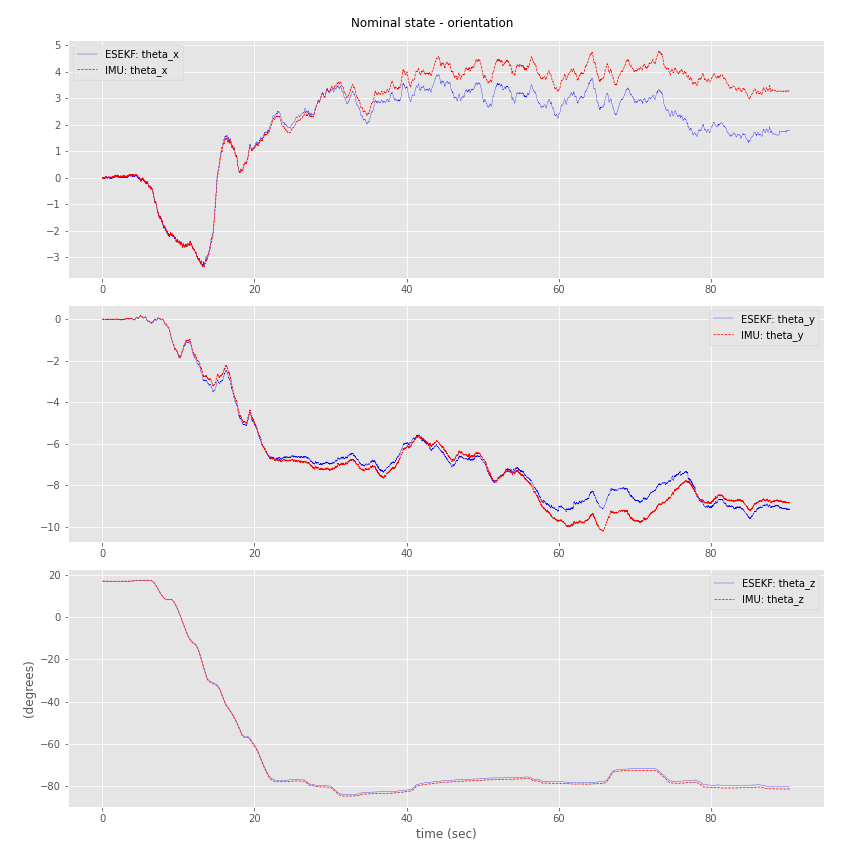

In [261]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, np.rad2deg(e_list[:,0]), 'b-', linewidth=0.3, label="ESEKF: theta_x")
axs[1].plot(t_list, np.rad2deg(e_list[:,1]), 'b-', linewidth=0.3, label="ESEKF: theta_y")
axs[2].plot(t_list, np.rad2deg(e_list[:,2]), 'b-', linewidth=0.3, label="ESEKF: theta_z")
  
axs[0].plot(tt_imu, np.rad2deg(theta_imu_list[:,0]), 'r--', linewidth=0.7, label="IMU: theta_x")
axs[1].plot(tt_imu, np.rad2deg(theta_imu_list[:,1]), 'r--', linewidth=0.7, label="IMU: theta_y")
axs[2].plot(tt_imu, np.rad2deg(theta_imu_list[:,2]), 'r--', linewidth=0.7, label="IMU: theta_z")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(degrees)")
plt.suptitle("Nominal state - orientation")
plt.show()

#### Angular velocity

In [241]:
w_list = np.zeros((1,3))
for i in range(1, len(t_list)):
    w = (e_list[i,:] - e_list[i-1, :])/(t_list[i] - t_list[i-1])
    w_list = np.append(w_list, [w.flatten()], axis=0)

In [242]:
# convert IMU angular velocity to base_link frame to compare to the ESEKF results
ang_vel_rotated = np.array([R_b2i.T@x.tolist() for x in ang_vel])

<IPython.core.display.Javascript object>


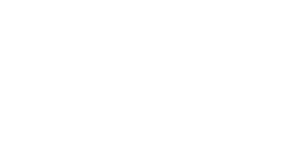

In [243]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, w_list[:,0], 'b-', linewidth=0.3, label="ESEKF: w_x")
axs[1].plot(t_list, w_list[:,1], 'b-', linewidth=0.3, label="ESEKF: w_y")
axs[2].plot(t_list, w_list[:,2], 'b-', linewidth=0.3, label="ESEKF: w_z")

axs[0].plot(tt_imu[0:len(x_list)], ang_vel_rotated[0:len(x_list),0], 'r--', 
            linewidth=0.6, label="IMU: w_x")
axs[1].plot(tt_imu[0:len(x_list)], ang_vel_rotated[0:len(x_list),1], 'r--', 
            linewidth=0.6, label="IMU: w_y")
axs[2].plot(tt_imu[0:len(x_list)], ang_vel_rotated[0:len(x_list),2], 'r--', 
            linewidth=0.6, label="IMU: w_z") 

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(deg/sec)")
plt.suptitle("Nominal state - angular velocity")
plt.show()

#### Angular velocity bias

<IPython.core.display.Javascript object>


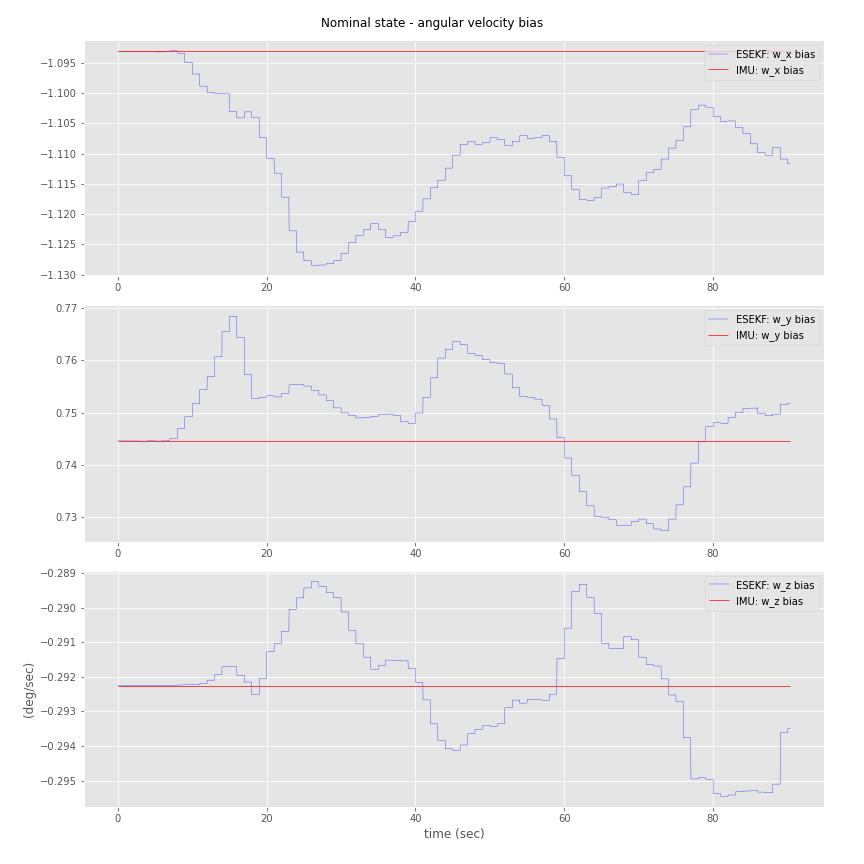

In [262]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, np.rad2deg(x_list[:,13]), 'b-', linewidth=0.3, label="ESEKF: w_x bias")
axs[1].plot(t_list, np.rad2deg(x_list[:,14]), 'b-', linewidth=0.3, label="ESEKF: w_y bias")
axs[2].plot(t_list, np.rad2deg(x_list[:,15]), 'b-', linewidth=0.3, label="ESEKF: w_z bias")

axs[0].hlines(np.rad2deg(ang_vel_imu_bias)[0], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_x bias")
axs[1].hlines(np.rad2deg(ang_vel_imu_bias)[1], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_y bias")
axs[2].hlines(np.rad2deg(ang_vel_imu_bias)[2], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_z bias")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(deg/sec)")
plt.suptitle("Nominal state - angular velocity bias")
plt.show()

### Translational movement

#### Position

<IPython.core.display.Javascript object>


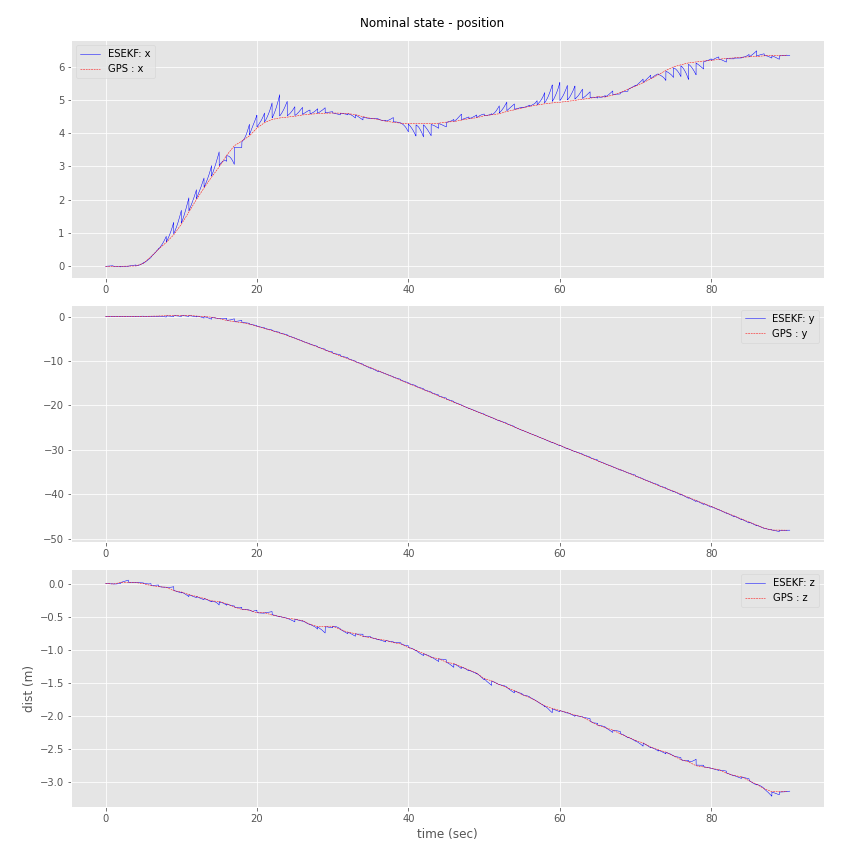

In [265]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, x_list[:,0], 'b-', linewidth=.5, label="ESEKF: x")
# axs[0].scatter(t_list, x_list[:,0], s=0.1, label="ESEKF: x")
axs[1].plot(t_list, x_list[:,1], 'b-', linewidth=.5, label="ESEKF: y")
axs[2].plot(t_list, x_list[:,2], 'b-', linewidth=.5, label="ESEKF: z")

axs[0].plot(t_gpss, x_gpss-gps_off[0], 'r--', 
            linewidth=.5, label="GPS : x")
axs[1].plot(t_gpss, y_gpss-gps_off[1], 'r--', 
            linewidth=.5, label="GPS : y")
axs[2].plot(t_gpss, z_gpss-gps_off[2], 'r--', 
            linewidth=.5, label="GPS : z")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("dist (m)")
plt.suptitle("Nominal state - position")
plt.show()

#### Velocity

<IPython.core.display.Javascript object>


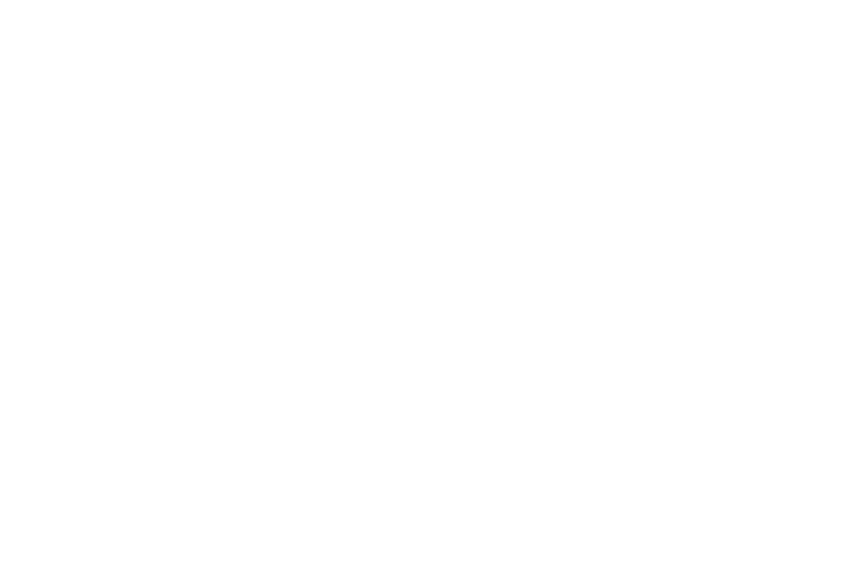

In [246]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, x_list[:,3], 'b-', linewidth=0.5, label="ESEKF: v_x")
axs[1].plot(t_list, x_list[:,4], 'b-', linewidth=0.5, label="ESEKF: v_y")
axs[2].plot(t_list, x_list[:,5], 'b-', linewidth=0.5, label="ESEKF: v_z")

axs[0].plot(tt_gps, vx_gps, 'r--', linewidth=0.5, label="GPS : v_x")
axs[1].plot(tt_gps, vy_gps, 'r--', linewidth=0.5, label="GPS : v_y")
axs[2].plot(tt_gps, vz_gps, 'r--', linewidth=0.5, label="GPS : v_z")
  
plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(m/sec)")
plt.suptitle("Nominal state - velocity")
plt.show()

#### Acceleration

In [247]:
a_list = np.zeros((1,3))
for i in range(1, len(t_list)):
    a = (x_list[i, 3:6] - x_list[i-1, 3:6])/(t_list[i] - t_list[i-1])
    a_list = np.append(a_list, [a.flatten()], axis=0)

<IPython.core.display.Javascript object>


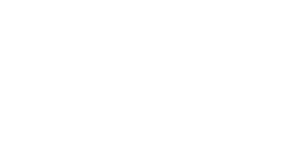

In [248]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, a_list[:,0], 'b-o', linewidth=0.3, label="ESEKF: a_x")
axs[1].plot(t_list, a_list[:,1], 'b-o', linewidth=0.3, label="ESEKF: a_y")
axs[2].plot(t_list, a_list[:,2], 'b-o', linewidth=0.3, label="ESEKF: a_z")

axs[0].plot(tt_imu[0:len(x_list)], lin_acc[0:len(x_list),0], 'r-x', 
            linewidth=0.3, label="IMU: a_x")
axs[1].plot(tt_imu[0:len(x_list)], lin_acc[0:len(x_list),1], 'r-x', 
            linewidth=0.3, label="IMU: a_y")
axs[2].plot(tt_imu[0:len(x_list)], lin_acc[0:len(x_list),2]-GRAV, 'r-x', 
            linewidth=0.3, label="IMU: a_z")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time(sec)")
plt.ylabel("(m/sec^2)")
plt.suptitle("Nominal state - acceleration")
plt.show()

#### Acceleration bias

<IPython.core.display.Javascript object>


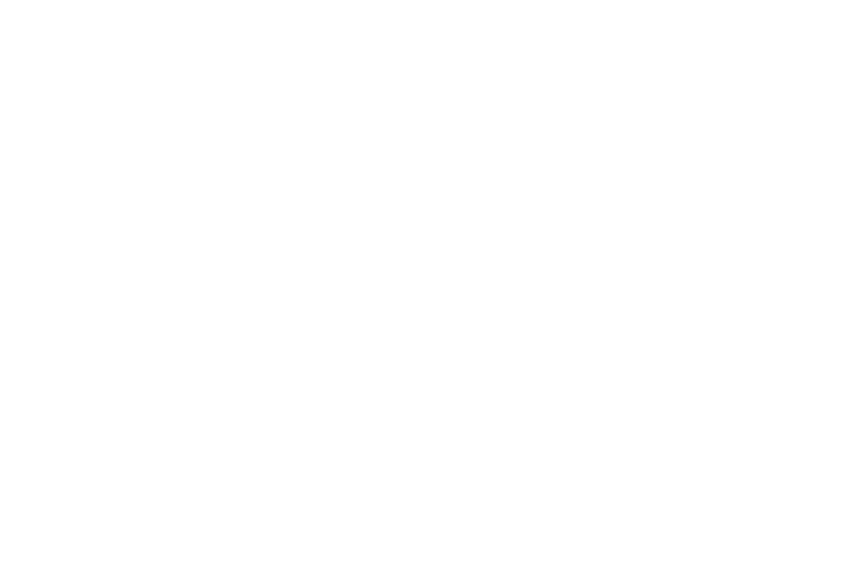

In [249]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, x_list[:,10], 'b-', linewidth=0.3, label="ESEKF: a_bx")
axs[1].plot(t_list, x_list[:,11], 'b-', linewidth=0.3, label="ESEKF: a_by")
axs[2].plot(t_list, x_list[:,12], 'b-', linewidth=0.3, label="ESEKF: a_bz")

axs[0].hlines(lin_acc_imu_bias[0], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_x bias")
axs[1].hlines(lin_acc_imu_bias[1], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_y bias")
axs[2].hlines(lin_acc_imu_bias[2], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_z bias")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time(sec)")
plt.ylabel("(m/sec^2)")
plt.suptitle("Nominal state - acceleration bias")
plt.show()

#### Gravity

<IPython.core.display.Javascript object>


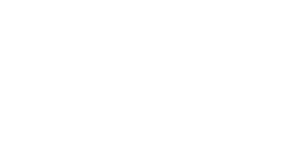

In [250]:
fig, axs = plt.subplots(3)

axs[0].plot(x_list[:,16], 'b-', markersize=0.3, linewidth=0.5, label="g_x")
axs[1].plot(x_list[:,17], 'b-', markersize=0.3, linewidth=0.5, label="g_y")
axs[2].plot(x_list[:,18], 'b--', markersize=0.3, linewidth=2, label="g_z")
axs[2].hlines(-GRAV, 0, len(x_list), 'r', linewidth=0.5, label="G.T. : g_z")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("# iteration")
plt.ylabel("(m/sec^2)")
plt.suptitle("Nominal state - gravity")
plt.show()

### Extrinsic calibration

<IPython.core.display.Javascript object>


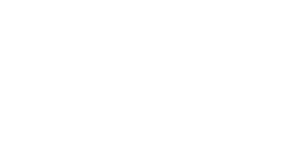

In [251]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, x_list[:,19], 'b--o', markersize=0.7, linewidth=2, label="p_i__x")
axs[1].plot(t_list, x_list[:,20], 'b--o', markersize=0.7, linewidth=2, label="p_i__y")
axs[2].plot(t_list, x_list[:,21], 'b--o', markersize=0.7, linewidth=2, label="p_i__z")
  
axs[0].hlines(gps_off[0], 0, t_list[-1], 'r', label="IMU : p_i_x")
axs[1].hlines(gps_off[1], 0, t_list[-1], 'r', label="IMU : p_i_y")
axs[2].hlines(gps_off[2], 0, t_list[-1], 'r', label="IMU : p_i_z")
    
plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(m)")
plt.suptitle("Nominal state - p_i (GPS sensor position)")
plt.show()

In [252]:
e_i_list = np.empty((0,3), float)
for x in x_list:
    e_i = quat2euler(x[22:26])
    e_i_list = np.append(e_i_list, [e_i.flatten()], axis=0)

<IPython.core.display.Javascript object>


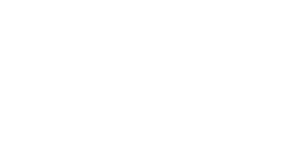

In [253]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, np.rad2deg(e_i_list)[:,0], 'b--', linewidth=3, label="θ_i__x")
axs[1].plot(t_list, np.rad2deg(e_i_list)[:,1], 'b--', linewidth=3, label="θ_i__y")
axs[2].plot(t_list, np.rad2deg(e_i_list)[:,2], 'b--', linewidth=3, label="θ_i__z")
  
axs[0].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_x")
axs[1].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_y")
axs[2].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_z")
            
plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(degrees)")
plt.suptitle("Nominal state - q_i (GPS sensor rotation)")
plt.show()

### Innovation

<IPython.core.display.Javascript object>


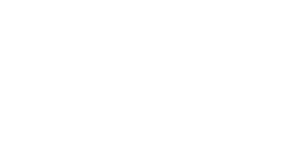

In [254]:
fig, axs = plt.subplots(3)

axs[0].plot(innovation_list[:,0], 'g-o', markersize=0.3, linewidth=0.3, label="gps_x - h(p_x)")
axs[1].plot(innovation_list[:,1], 'g-o', markersize=0.3, linewidth=0.3, label="gps_y - h(p_y)")
axs[2].plot(innovation_list[:,2], 'g-o', markersize=0.3, linewidth=0.3, label="gps_z - h(p_z)")
  
plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Set common labels
plt.ylabel("difference (m)")
plt.xlabel("# iteration")
fig.suptitle("Innovation term - position")
plt.show()

### Error state

#### Position

<IPython.core.display.Javascript object>


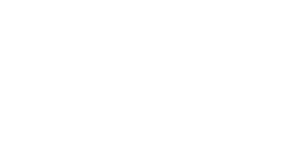

In [255]:
fig, axs = plt.subplots(3)

t = np.arange(len(dx_list))

axs[0].scatter(t, dx_list[:,0], marker='o', color='r', s=.5, label="dx")
axs[1].scatter(t, dx_list[:,1], marker='o', color='g', s=.5, label="dy")
axs[2].scatter(t, dx_list[:,2], marker='o', color='b', s=.5, label="dz")
  

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Set common labels
plt.ylabel("m")
plt.xlabel("# iteration")
fig.suptitle("Error state position")
plt.show()

#### Orientation

<IPython.core.display.Javascript object>


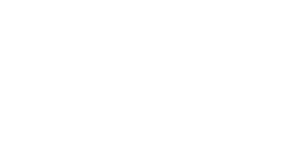

In [256]:
fig, axs = plt.subplots(3)

t = np.arange(len(dx_list))

axs[0].scatter(t, np.rad2deg(dx_list[:,6]), marker='o', color='r', s=0.3, label="dx")
axs[1].scatter(t, np.rad2deg(dx_list[:,7]), marker='o', color='g', s=0.3, label="dy")
axs[2].scatter(t, np.rad2deg(dx_list[:,8]), marker='o', color='b', s=0.3, label="dz")  

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Set common labels
plt.ylabel("degrees")
plt.xlabel("time (sec)")
fig.suptitle("Error state - Orientation")
plt.show()

## Trajectory in 2d

<IPython.core.display.Javascript object>


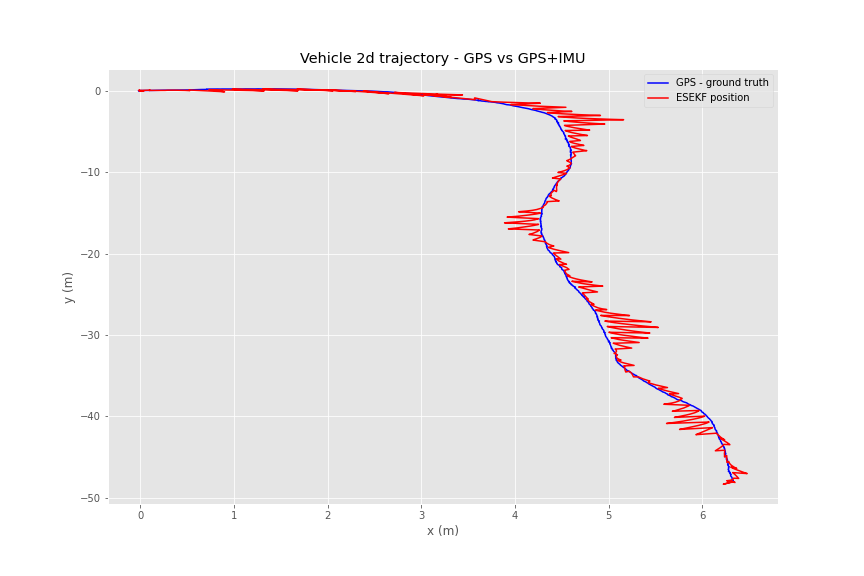

In [259]:
fig, axs = plt.subplots(figsize=(12,8))

axs.plot(x_gps, y_gps, 'b-', label = "GPS - ground truth")
axs.plot(x_list[:,0], x_list[:,1], 'r-', label = "ESEKF position")

plt.title("Vehicle 2d trajectory - GPS vs GPS+IMU")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


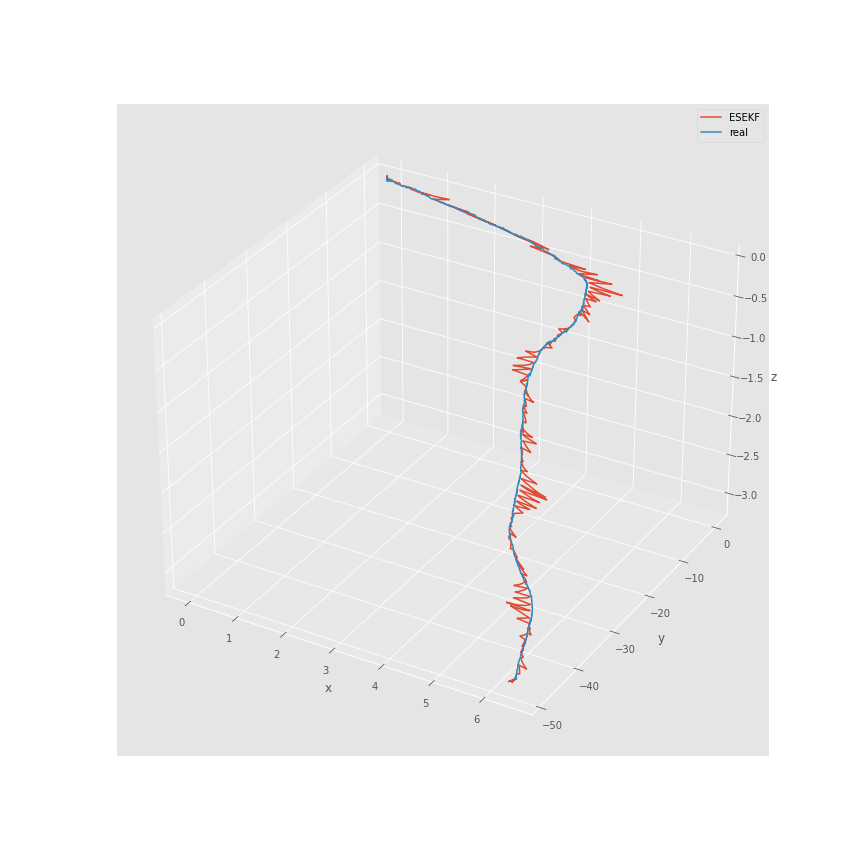

In [258]:
%matplotlib notebook
plt.rcParams["figure.figsize"] = (12,12)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.plot(x_list[:,0], x_list[:,1], x_list[:,2], label="ESEKF")
ax.plot(x_gps.flatten()-gps_off[0], y_gps.flatten()-gps_off[1], z_gps.flatten()-gps_off[2], label="real")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.legend()
plt.show()